In [1]:
# libraries
%matplotlib notebook

import pandas as pd
import numpy as np
#import scipy as sc
# import custom_function as cf

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
# from pyemma import msm
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
# from fbprophet import Prophet

# 1 Data
## 1.1 Extract data
The dataset is from https://www.kaggle.com/boltzmannbrain/nab 
In realKnownCause/ambient_temperature_system_failure.csv

In [2]:
df = pd.read_csv("realKnownCause/realKnownCause/ambient_temperature_system_failure.csv")

## 1.2 Understand data

In [3]:
print(df.head())

             timestamp      value
0  2013-07-04 00:00:00  69.880835
1  2013-07-04 01:00:00  71.220227
2  2013-07-04 02:00:00  70.877805
3  2013-07-04 03:00:00  68.959400
4  2013-07-04 04:00:00  69.283551


In [4]:
# check the timestamp format and frequence 
print(df['timestamp'].head(10))

0    2013-07-04 00:00:00
1    2013-07-04 01:00:00
2    2013-07-04 02:00:00
3    2013-07-04 03:00:00
4    2013-07-04 04:00:00
5    2013-07-04 05:00:00
6    2013-07-04 06:00:00
7    2013-07-04 07:00:00
8    2013-07-04 08:00:00
9    2013-07-04 09:00:00
Name: timestamp, dtype: object


In [5]:
# check the temperature mean
print(df['value'].mean())
print(df.shape)

71.2424327082882
(7267, 2)


<IPython.core.display.Javascript object>


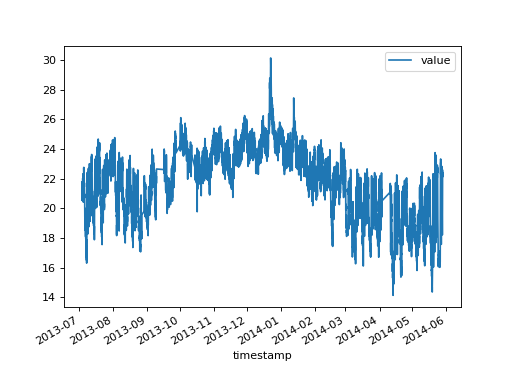

In [6]:
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9
# plot the data
df.plot(x='timestamp', y='value')

## 1.3 Feature engineering
Extracting some useful features

In [7]:
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [22]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

In [23]:
# Take useful feature and standardize them 
data = df[['value']]#, 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]

# for c in ['hours', 'daylight', 'DayOfTheWeek', 'WeekDay']:
# #     print(c)
#     print(f"{c} unique values :{data[c].unique()}")
print(data.shape)
data.head()

(7267, 1)


,value
0,21.044908
1,21.789015
2,21.598781
3,20.533000
4,20.713084


In [37]:
from sklearn.neighbors import LocalOutlierFactor

min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  LocalOutlierFactor(n_neighbors=50, novelty=True)
data = pd.DataFrame(np_scaled)

test_items = 3000 ## last how many items

model.fit(data[:data.shape[0]-test_items])
# add the data to the main  


full_span = pd.concat([pd.Series([0 for _ in range(data.shape[0]-test_items)]), pd.Series(model.predict(data[data.shape[0]-test_items: data.shape[0]]))], ignore_index=True)
print(data.shape)
print(full_span.shape)
df['anomaly26'] = full_span
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

(7267, 1)
(7267,)
0.0    2692
1.0     308
Name: anomaly26, dtype: int64


<IPython.core.display.Javascript object>


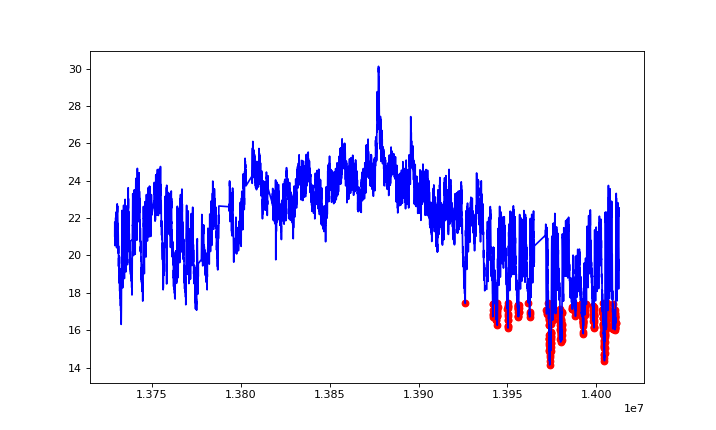

In [38]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()